# From trained model to HW using the finn compiler

We will go through network preparation and conversion

In [1]:
# get onnx model from last LAB
filename = "/tmp/finn_dev_rootmin/LAB1_finnonnx.onnx"

In [2]:
from finn.util.visualization import showSrc, showInNetron
showInNetron(filename)

Serving '/tmp/finn_dev_rootmin/LAB1_finnonnx.onnx' at http://0.0.0.0:8081


## Network preparing for finn

- Tidy up (and also after EACH step)
- Pre (data feed) / Post proc (top k)
- Model streamlining
- Model Preparation (merge into HLS convertibles)
- Model HW Layers
- Model data flow partitions
- Specialize layer, ready for hw conversion (hls)

In [3]:
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.core.modelwrapper import ModelWrapper

model = ModelWrapper(filename)

# TIDY UP
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())

model.save("/tmp/finn_dev_rootmin/tidy.onnx")

In [4]:
showInNetron("/tmp/finn_dev_rootmin/tidy.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/tidy.onnx' at http://0.0.0.0:8081


In [5]:
from finn.util.pytorch import ToTensor
from qonnx.transformation.merge_onnx_models import MergeONNXModels
from qonnx.core.datatype import DataType
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
import torch

# PRE PROC : NONE
model = ModelWrapper("/tmp/finn_dev_rootmin/tidy.onnx")

"""
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)
# inputs are 0 to 255 and the model consumes -1 to 1 range
# to adapt, we do preprocessing : (input*2)-1
# TODO HERE (for now i'll just check if it works)
totensor_pyt = ToTensor()
export_qonnx(totensor_pyt, torch.randn(ishape), "/tmp/finn_dev_rootmin/preproc.onnx")
qonnx_cleanup("/tmp/finn_dev_rootmin/preproc.onnx",out_file="/tmp/finn_dev_rootmin/preproc_clean.onnx")
pre_model = ModelWrapper("/tmp/finn_dev_rootmin/preproc_clean.onnx")

#merge preproc and model and add an annotation (we rack in UINT8)
model = model.transform(MergeONNXModels(pre_model))
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType["UINT8"])
"""


model.save("/tmp/finn_dev_rootmin/full_preproc.onnx")
showInNetron("/tmp/finn_dev_rootmin/full_preproc.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/full_preproc.onnx' at http://0.0.0.0:8081


In [6]:
from qonnx.transformation.insert_topk import InsertTopK

# POST PROC

# insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = "/tmp/finn_dev_rootmin/pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(chkpt_name)

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/pre_post.onnx' at http://0.0.0.0:8081


In [7]:
from finn.transformation.streamline import Streamline
# we can see the list of apllied transformations here : showSrc(Streamline)
from finn.transformation.streamline.reorder import MoveScalarLinearPastInvariants
import finn.transformation.streamline.absorb as absorb

model = ModelWrapper("/tmp/finn_dev_rootmin/pre_post.onnx")
# STREAMLINE
model = model.transform(Streamline())
model.save("/tmp/finn_dev_rootmin/streamlined.onnx")
showInNetron("/tmp/finn_dev_rootmin/streamlined.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/streamlined.onnx' at http://0.0.0.0:8081


In [8]:
# MODEL PREP

from qonnx.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
from finn.transformation.streamline.round_thresholds import RoundAndClipThresholds
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.general import RemoveUnusedTensors

model = ModelWrapper("/tmp/finn_dev_rootmin/streamlined.onnx")

model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(absorb.AbsorbAddIntoMultiThreshold())
model = model.transform(absorb.AbsorbMulIntoMultiThreshold())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(RoundAndClipThresholds())

# bit of tidy-up
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())

model.save("/tmp/finn_dev_rootmin/streamlined_merged_and_ready.onnx")
showInNetron("/tmp/finn_dev_rootmin/streamlined_merged_and_ready.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/streamlined_merged_and_ready.onnx' at http://0.0.0.0:8081


/home/rootmin/Documents/freelance/mission2/finn/deps/qonnx/src/qonnx/transformation/infer_data_layouts.py:136: UserWarning: Assuming 2D input is NC
  warnings.warn("Assuming 2D input is NC")


In [11]:
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw

# TO HW LAYERS

model = ModelWrapper("/tmp/finn_dev_rootmin/streamlined_merged_and_ready.onnx")
model = model.transform(to_hw.InferLabelSelectLayer())
model = model.transform(to_hw.InferChannelwiseLinearLayer())
model = model.transform(to_hw.InferQuantizedMatrixVectorActivation())
model = model.transform(to_hw.InferThresholdingLayer())
model.save("/tmp/finn_dev_rootmin/hw.onnx")
showInNetron("/tmp/finn_dev_rootmin/hw.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/hw.onnx' at http://0.0.0.0:8081


In [10]:
from finn.transformation.fpgadataflow.create_dataflow_partition import CreateDataflowPartition

model = ModelWrapper("/tmp/finn_dev_rootmin/hw.onnx")
parent_model = model.transform(CreateDataflowPartition())
parent_model.save("/tmp/finn_dev_rootmin/df_part.onnx")
showInNetron("/tmp/finn_dev_rootmin/df_part.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/df_part.onnx' at http://0.0.0.0:8081


In [11]:
from qonnx.custom_op.registry import getCustomOp
sdp_node = parent_model.get_nodes_by_op_type("StreamingDataflowPartition")[0]
sdp_node = getCustomOp(sdp_node)
dataflow_model_filename = sdp_node.get_nodeattr("model")
showInNetron(dataflow_model_filename)

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/dataflow_partition_3drkli5k/partition_0.onnx' at http://0.0.0.0:8081


In [12]:
# print the names of the supported PYNQ boards
from finn.util.basic import pynq_part_map
print(pynq_part_map.keys())

dict_keys(['Ultra96', 'Ultra96-V2', 'Pynq-Z1', 'Pynq-Z2', 'ZCU102', 'ZCU104', 'ZCU111', 'RFSoC2x2', 'RFSoC4x2', 'KV260_SOM'])


In [13]:
# change this if you have a different PYNQ board, see list above
pynq_board = "Pynq-Z1"
fpga_part = pynq_part_map[pynq_board]
target_clk_ns = 20

In [14]:
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
model = ModelWrapper(dataflow_model_filename)

model = model.transform(SpecializeLayers(fpga_part))

model.save("/tmp/finn_dev_rootmin/to_hw_conv.onnx")
showInNetron("/tmp/finn_dev_rootmin/to_hw_conv.onnx")

Stopping http://0.0.0.0:8081
Serving '/tmp/finn_dev_rootmin/to_hw_conv.onnx' at http://0.0.0.0:8081


# HARDWARE BUILD

In [15]:
# ESTIMATE
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "/tmp/finn_dev_rootmin/to_hw_conv.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xc7z020clg400-1",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

build.build_dataflow_cfg(model_file, cfg_estimates)

Previous run results deleted!
Building dataflow accelerator from /tmp/finn_dev_rootmin/to_hw_conv.onnx
Intermediate outputs will be generated in /tmp/finn_dev_rootmin
Final outputs will be generated in output_estimates_only
Build log is at output_estimates_only/build_dataflow.log
Running step: step_qonnx_to_finn [1/10]
Running step: step_tidy_up [2/10]
Running step: step_streamline [3/10]
Running step: step_convert_to_hw [4/10]
Running step: step_create_dataflow_partition [5/10]
Running step: step_specialize_layers [6/10]
Running step: step_target_fps_parallelization [7/10]
Running step: step_apply_folding_config [8/10]
Running step: step_minimize_bit_width [9/10]
Running step: step_generate_estimate_reports [10/10]
Completed successfully


0

In [16]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

{
  "critical_path_cycles": 252,
  "max_cycles": 98,
  "max_cycles_node_name": "MVAU_hls_0",
  "estimated_throughput_fps": 1020408.1632653062,
  "estimated_latency_ns": 2520.0
}

In [17]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

{'MVAU_hls_0': 98, 'MVAU_hls_1': 64, 'MVAU_hls_2': 80, 'LabelSelect_hls_0': 10}

In [18]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

{'MVAU_hls_0': {'BRAM_18K': 57,
  'BRAM_efficiency': 0.19103313840155944,
  'LUT': 8994,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_1': {'BRAM_18K': 8,
  'BRAM_efficiency': 0.1111111111111111,
  'LUT': 3133,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'MVAU_hls_2': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.1388888888888889,
  'LUT': 657,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'LabelSelect_hls_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'total': {'BRAM_18K': 66.0, 'LUT': 12784.0, 'URAM': 0.0, 'DSP': 0.0}}

In [19]:
# Actual hardware build, ZYNQ BUILD
from finn.transformation.fpgadataflow.make_zynq_proj import ZynqBuild

model = ModelWrapper("/tmp/finn_dev_rootmin/to_hw_conv.onnx")
model = model.transform(ZynqBuild(platform = pynq_board, period_ns = target_clk_ns,partition_model_dir="./test",enable_debug=True))

/home/rootmin/Documents/freelance/mission2/finn/src/finn/transformation/fpgadataflow/floorplan.py:107: UserWarning: 6 nodes have no entry in the provided floorplan, SLR was set to -1
  warnings.warn(
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/

KeyboardInterrupt: 

In [ ]:
model.save("/tmp/finn_dev_rootmin/post_synth.onnx")

In [ ]:
showInNetron("/tmp/finn_dev_rootmin/post_synth.onnx")

In [ ]:
model = ModelWrapper("/tmp/finn_dev_rootmin/post_synth.onnx")

In [ ]:
model.model.metadata_props
# en fouillant un peu, on voit le projete mère avec deuc couvhes IODMA
# et en ouvrant le stiched projet de la couche du milleu on retrouve notre modèle (voir ci-dessous)

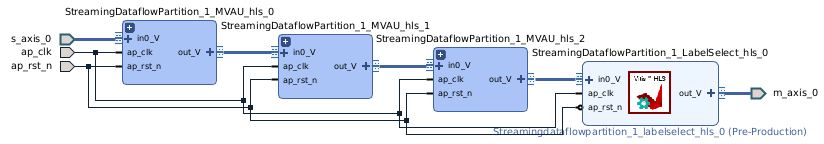

In [ ]:
# On remarque également que notre modèle demande 8bits par 8bits
# ce qui veut dire qu'une image en tière se charge en 28*28*8/8 = 784 cycles
# avec 20ns par cycle = 15 680 ns / images soit 63 000 images /sec
# (en théorie.)

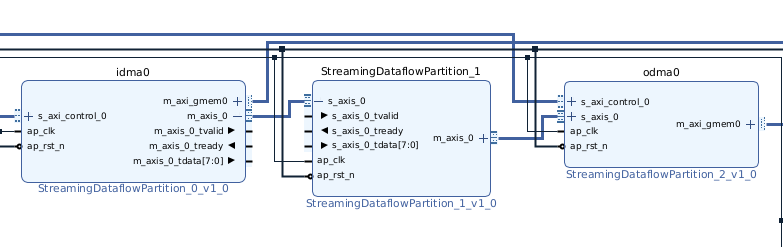  